In [2]:
import sklearn.datasets
import urllib.request

import numpy as np
import matplotlib.pyplot as plt

from optimizer.loss import LogisticRegression
from optimizer.cubic import Cubic, Cubic_LS, Cubic_Krylov_LS, SSCN
from optimizer.GD import Gd, GD_LS
from optimizer.reg_newton import RegNewton

In [120]:
dataset = 'a6a'
    # if dataset == 'mushrooms':
    #     data_url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/mushrooms"
    #     data_path = './mushrooms'
    # else:
    #     data_url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/w8a"
    #     data_path = './w8a'
data_url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/{}".format(dataset)
data_path = './{}'.format(dataset)

f = urllib.request.urlretrieve(data_url, data_path)
A, b = sklearn.datasets.load_svmlight_file(data_path)
A = A.toarray()

In [121]:
print(A.shape)

(11220, 122)


In [122]:
loss = LogisticRegression(A, b, l1=0, l2=0)
n, dim = A.shape
L = loss.smoothness
l2 = 1e-10 * L # make the problem ill-conditioned
loss.l2 = l2
x0 = np.ones(dim) * 0.5
it_max = 200
memory_size = 10

In [6]:
gd = GD_LS(loss=loss, label='GD LS')

cub_krylov = Cubic_Krylov_LS(loss=loss, label='Cubic Newton LS (Krylov dim = {})'.format(memory_size),
                               subspace_dim=memory_size, tolerance = 1e-9)

cub_root = Cubic_LS(loss=loss, label='Cubic Newton LS', tolerance = 1e-8)

adan = RegNewton(loss=loss, adaptive=True, use_line_search=True, 
                    label='AdaN')

In [7]:
print(f'Running optimizer: {gd.label}')
gd.run(x0=x0, it_max=it_max)
gd.compute_loss_of_iterates()

Running optimizer: GD LS


100%|██████████| 200/200 [00:04<00:00, 44.53it/s]


In [8]:
print(f'Running optimizer: {cub_krylov.label}')
cub_krylov.run(x0=x0, it_max=it_max)
cub_krylov.compute_loss_of_iterates()

Running optimizer: Cubic Newton LS (Krylov dim = 10)


100%|██████████| 200/200 [00:31<00:00,  6.44it/s]


In [9]:
print(f'Running optimizer: {adan.label}')
adan.run(x0=x0, it_max=50)
adan.compute_loss_of_iterates()

Running optimizer: AdaN


100%|██████████| 50/50 [00:10<00:00,  4.72it/s]


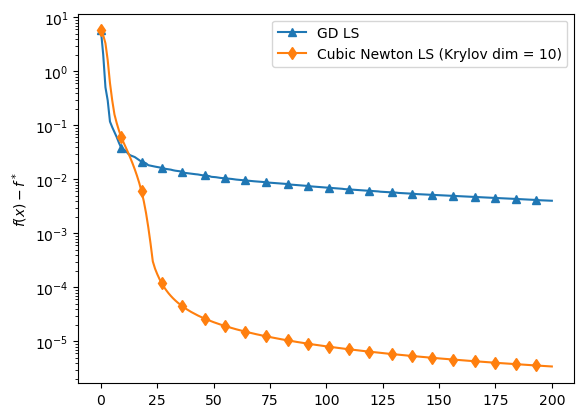

In [10]:
gd.trace.plot_losses(marker='^')
cub_krylov.trace.plot_losses(marker='d')

# cub_root.trace.plot_losses(marker='*', label='cubic Newton (exact)')
# plt.xscale('log')
# print(cub.trace.loss_vals)
plt.yscale('log')
plt.legend()
plt.show()

In [44]:
from optimizer.cubic import Optimizer, Lanczos, cubic_solver_root
from scipy.linalg import eigh

class Cubic_Krylov_LS_test(Optimizer):
    """
    Krylov subspace cubic Newton method with line search
    
    Arguments:
        
    """
    def __init__(self, reg_coef=None, subspace_dim=100, solver_eps=1e-8, beta=0.5, *args, **kwargs):
        super(Cubic_Krylov_LS_test, self).__init__(*args, **kwargs)    
        self.solver_it = 0
        self.subspace_dim = subspace_dim
        self.solver_eps = solver_eps

        self.beta = beta
        self.r0 = 0.1
        # self.residuals = []
        self.value = None

        if reg_coef is None:
            self.reg_coef = self.loss.hessian_lipschitz
        else:
            self.reg_coef = reg_coef
        
        # if cubic_solver == "GD": 
        #     self.cubic_solver = ls_cubic_solver
        # elif cubic_solver == "root":
        #     self.cubic_solver = cubic_solver_root
        # elif cubic_solver == "krylov":
        #     self.cubic_solver = cubic_solver_krylov
        # else:
        #     print("Error: cubic_solver not recognized")

        # if cubic_solver is None:
        #     # self.cubic_solver = ls_cubic_solver
        #     self.cubic_solver = cubic_solver_root
        self.spectra = []
        self.rho = []

    def step(self):
        
        if self.value is None:
            self.value = self.loss.value(self.x)
        
        
        self.grad = self.loss.gradient(self.x)


        self.hess = self.loss.hessian(self.x)
        h_eigs = eigh(self.hess, eigvals_only=True)
        self.spectra.append(h_eigs)

        # if self.cubic_solver is cubic_solver_krylov:    
        self.hess = lambda v: self.loss.hess_vec_prod(self.x,v)
            # krylov_start = time.time()
        V, alphas, betas, beta = Lanczos(self.hess, self.grad, m=self.subspace_dim)
            # krylov_end = time.time()
            # print('Krylov Time {time:.3f}'.format(time=krylov_end - krylov_start))
        self.hess = np.diag(alphas) + np.diag(betas, -1) + np.diag(betas, 1)

        np.append(betas,beta)
        self.rho.append(np.exp(np.log(betas).mean()))

        e1 = np.zeros(len(alphas))
        e1[0] = 1
        self.grad = np.linalg.norm(self.grad)*e1

        if np.linalg.norm(self.grad) < self.tolerance:
            return
        # set the initial value of the regularization coefficient
        reg_coef = self.reg_coef*self.beta

        # LS_start = time.time()

        s_new, solver_it, r0_new, model_decrease = cubic_solver_root(self.grad, self.hess, 
        reg_coef, epsilon = self.solver_eps, r0 = self.r0)
        x_new = self.x + V @ s_new
        value_new = self.loss.value(x_new)
        while value_new > self.value - model_decrease:
            reg_coef = reg_coef/self.beta
            s_new, solver_it, r0_new, model_decrease = cubic_solver_root(self.grad, self.hess, 
            reg_coef, epsilon = self.solver_eps, r0 = self.r0)
            x_new = self.x + V @ s_new
            value_new = self.loss.value(x_new)
        self.x = x_new
        self.reg_coef = reg_coef
        self.value = value_new
        self.r0 = r0_new
        
        self.solver_it += solver_it

        # if model_decrease < 1e-6:
        #     self.subspace_dim = 1
        # self.residuals.append(residual)
        # LS_end = time.time()
        # print('LS Time {time:.3f}'.format(time=LS_end - LS_start))
        
    def init_run(self, *args, **kwargs):
        super(Cubic_Krylov_LS_test, self).init_run(*args, **kwargs)
        self.trace.solver_its = [0]
        
    def update_trace(self):
        super(Cubic_Krylov_LS_test, self).update_trace()
        self.trace.solver_its.append(self.solver_it)

In [146]:
memory_size = 20
cub_krylov_test = Cubic_Krylov_LS_test(loss=loss, label='Cubic Newton LS (Krylov dim = {})'.format(memory_size),
                               subspace_dim=memory_size, tolerance = 1e-9)

In [147]:
print(f'Running optimizer: {cub_krylov_test.label}')
cub_krylov_test.run(x0=x0, it_max=100)
# cub_krylov.compute_loss_of_iterates()

Running optimizer: Cubic Newton LS (Krylov dim = 20)


100%|██████████| 100/100 [00:04<00:00, 22.53it/s]


In [148]:
spectra = np.array(cub_krylov_test.spectra)

In [149]:
spectra.shape

(100, 122)

In [150]:
rho = np.array(cub_krylov_test.rho)

In [151]:
rho

array([0.00013428, 0.00334939, 0.03127041, 0.0264015 , 0.02279411,
       0.02035408, 0.01844052, 0.017534  , 0.0166544 , 0.01618742,
       0.0154178 , 0.01627892, 0.01468412, 0.01434622, 0.01630395,
       0.01596597, 0.01592888, 0.01666777, 0.01653872, 0.01576803,
       0.01600029, 0.01661015, 0.01647344, 0.01579416, 0.01500579,
       0.01653036, 0.01567663, 0.01615778, 0.01613962, 0.01579085,
       0.01625959, 0.01591065, 0.01555832, 0.0163101 , 0.01632038,
       0.01524626, 0.01547386, 0.01679761, 0.01636624, 0.01608203,
       0.01633488, 0.01537839, 0.01603148, 0.01668596, 0.01580871,
       0.01576049, 0.015801  , 0.01487915, 0.01541401, 0.01653515,
       0.01628014, 0.01408876, 0.01618254, 0.01612999, 0.01753606,
       0.01655054, 0.01756388, 0.01657596, 0.01608967, 0.01492064,
       0.01561737, 0.01615663, 0.01713821, 0.01644836, 0.01540172,
       0.01646336, 0.01684953, 0.01663662, 0.01681674, 0.01666969,
       0.01550803, 0.01623364, 0.01634854, 0.01646752, 0.01552

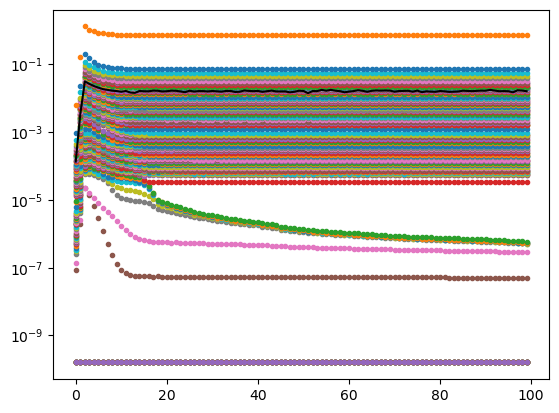

In [154]:
import matplotlib.pyplot as plt
for i in range(spectra.shape[1]):
    plt.semilogy(spectra[:,i],'.')

# plt.figure()
# plt.semilogy(spectra[:,-memory_size], '.')
plt.plot(rho,'k')
plt.show()

In [153]:

plt.show()